In [1]:
from torchvision import models
import torchvision.transforms as transforms
import torch.nn as nn
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
# Modelo Resnet50 pre-entrenado en ImageNet.
model = models.resnet50(pretrained=True)

# Referencia a la ultima capa convolucional del modelo.
final_conv_layer = model._modules.get('layer4')

In [3]:
# Esta clase almacena los feature maps de la ultima capa convolucional de la imagen, luego de un forward pass.
class FeatureBuffer():

    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, _input, _output): 
        self.features = _output

    def remove(self): 
        self.hook.remove()

# Register hook.
fb = FeatureBuffer(final_conv_layer)

In [4]:
# Data pre-process.
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

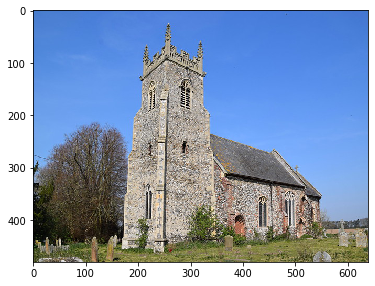

In [5]:
# Example picture.
plt.figure(figsize=(6, 6))
img = Image.open('input_images/church.jpg').convert('RGB')
plt.imshow(img)
plt.show()

In [6]:
# Prepare input.
input_tensor = transform(img).unsqueeze(0)

# Model in evaluation mode.
model = model.eval()

# Get probabilities and feature maps.
out = model(input_tensor)
feature_maps = fb.features

# 1000 classes, and 2028xWxH feature maps ((W,H)depend on image's size after pre-processing).
print("Output's shape: ", out.shape)
print("Feature maps's shape: ", feature_maps.shape)

Output's shape:  torch.Size([1, 1000])
Feature maps's shape:  torch.Size([1, 2048, 7, 10])


In [7]:
# Get probs from output as torchvision models do not have this final layer.
# If you do not care about the score, then you only need to find the max and ommit this line :).
probs = torch.nn.functional.softmax(out[0], dim=0)

# Find out which class image belongs.
score, _class = torch.max(probs, dim=0)
print("Score: ", score.item(), " Class: ", _class.item(), "- Church, Church Building")

Score:  0.944129467010498  Class:  497 - Church, Church Building


In [8]:
# Get weights and biases for fully conected linear layer.
weights_and_biases = list(model._modules.get('fc').parameters())
print("Weights's shape: ", weights_and_biases[0].shape)
print("Biases's shape: ", weights_and_biases[1].shape)

# Get weights for the class's neuron.
class_weights = weights_and_biases[0][_class]
print("Class weights's shape :", class_weights.shape)

Weights's shape:  torch.Size([1000, 2048])
Biases's shape:  torch.Size([1000])
Class weights's shape : torch.Size([2048])


In [9]:
# Weights must be reshaped to match feature maps's dimension.
class_weights = class_weights.reshape((-1, 1, 1))
print("Class weights's shape :", class_weights.shape)

# We can also reduce one empty dimension (first one) of the feature maps.
feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
print("Feature maps's shape: ", feature_maps.shape)

Class weights's shape : torch.Size([2048, 1, 1])
Feature maps's shape:  torch.Size([2048, 7, 10])


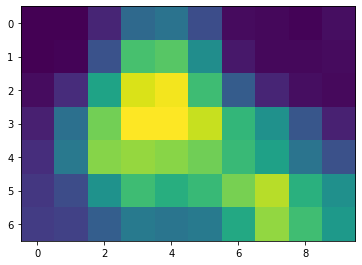

In [10]:
# Get class_activation maps
class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
plt.figure(figsize=(6, 6))
plt.imshow(class_activation_maps)
plt.show()

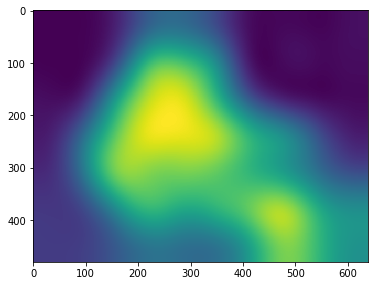

In [11]:
# Types of interpolation are:
# cv2.INTER_NEAREST
# cv2.INTER_LINEAR
# cv2.INTER_AREA
# cv2.INTER_CUBIC
# cv2.INTER_LANCZOS4
# We choose last one, as it makes up for the low quallity of the class activation map.

# Resize tensor to match original image's size.
resized_cam = cv2.resize(class_activation_maps, dsize=img.size, interpolation=cv2.INTER_LANCZOS4)
plt.figure(figsize=(6, 6))
plt.imshow(resized_cam)
plt.show()

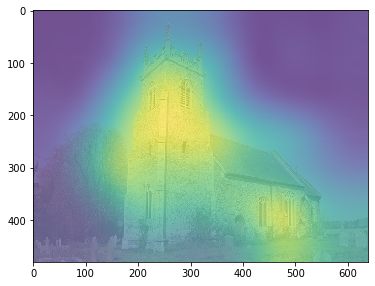

In [12]:
# Visualization of the class activation map, over the original image.
plt.figure(figsize=(6, 6))
plt.imshow(img, alpha=0.4)
plt.imshow(resized_cam, alpha=0.6)
plt.show()